In [16]:
import os
import pandas as pd

base_path = "../data/raw"
classes = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

rows = []
for c in classes:
    class_dir = os.path.join(base_path, c)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".wav", ".mp3")):
            rows.append({"class": c, "path": os.path.join(class_dir, fname)})

df = pd.DataFrame(rows)
df.head(), df["class"].value_counts()


(        class                                               path
 0  belly_pain  ../data/raw/belly_pain/999bf14b-e417-4b44-b746...
 1  belly_pain  ../data/raw/belly_pain/C421C6FE-DFEE-4080-8AEA...
 2  belly_pain  ../data/raw/belly_pain/d6cda191-4962-4308-9a36...
 3  belly_pain  ../data/raw/belly_pain/643D64AD-B711-469A-AF69...
 4  belly_pain  ../data/raw/belly_pain/643D64AD-B711-469A-AF69...,
 class
 hungry        382
 discomfort     30
 tired          28
 scared         20
 burping        18
 belly_pain     16
 lonely         11
 cold_hot        7
 Name: count, dtype: int64)

### Train/val/test split

In [17]:
from sklearn.model_selection import train_test_split

# encode labels
label2id = {c:i for i,c in enumerate(classes)}
df["label"] = df["class"].map(label2id)

df_train_full, df_test = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df["label"], shuffle=True
)

df_train, df_val = train_test_split(
    df_train_full, test_size=0.25, random_state=42, stratify=df_train_full["label"], shuffle=True
)
# => train 60%, val 20%, test 20%

df_train.shape, df_val.shape, df_test.shape


((306, 3), (103, 3), (103, 3))

In [18]:
# Save splits
os.makedirs("../data/splits", exist_ok=True)
df_train.to_csv("../data/splits/train.csv", index=False)
df_val.to_csv("../data/splits/val.csv", index=False)
df_test.to_csv("../data/splits/test.csv", index=False)

import json
with open("../data/splits/label_map.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": {v:k for k,v in label2id.items()}}, f, indent=2)


### Define trim/pad + mel spectrogram functions

In [19]:
import numpy as np
import librosa

TARGET_SR = 8000
CLIP_SECONDS = 7.0
FIXED_LEN = int(TARGET_SR * CLIP_SECONDS)

N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 256

def load_and_fix_length(path, target_sr=TARGET_SR, fixed_len=FIXED_LEN):
    # load and resample if needed
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    
    # trim or pad to fixed length
    if len(y) > fixed_len:
        y = y[:fixed_len]  # simple: take first 7 seconds
    elif len(y) < fixed_len:
        y = np.pad(y, (0, fixed_len - len(y)))
    return y

In [20]:
def to_mel_spectrogram(y, sr=TARGET_SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

In [21]:
def normalize_0_1(x):
    # normalize per-sample for stability
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min + 1e-9)

### Convert a split into X/y arrays and save

In [28]:
from tqdm import tqdm

def build_xy(df):
    X_list = []
    y_list = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        y = load_and_fix_length(row["path"])
        mel_db = to_mel_spectrogram(y)
        mel_norm = normalize_0_1(mel_db)
        
        # add channel dimension: (1, n_mels, time)
        X_list.append(mel_norm[np.newaxis, :, :])
        y_list.append(row["label"])
        
    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list).astype(np.int64)
    return X, y

os.makedirs("../data/processed", exist_ok=True)

X_train, y_train = build_xy(df_train)
X_val, y_val = build_xy(df_val)
X_test, y_test = build_xy(df_test)

X_train.shape, y_train.shape, X_test.shape


100%|██████████| 103/103 [00:00<00:00, 234.88it/s]


((306, 1, 128, 219), (306,), (103, 1, 128, 219))

In [23]:
np.save("../data/processed/X_train.npy", X_train)
np.save("../data/processed/y_train.npy", y_train)

np.save("../data/processed/X_val.npy", X_val)
np.save("../data/processed/y_val.npy", y_val)

np.save("../data/processed/X_test.npy", X_test)
np.save("../data/processed/y_test.npy", y_test)

### Quick sanity check plot (important!)

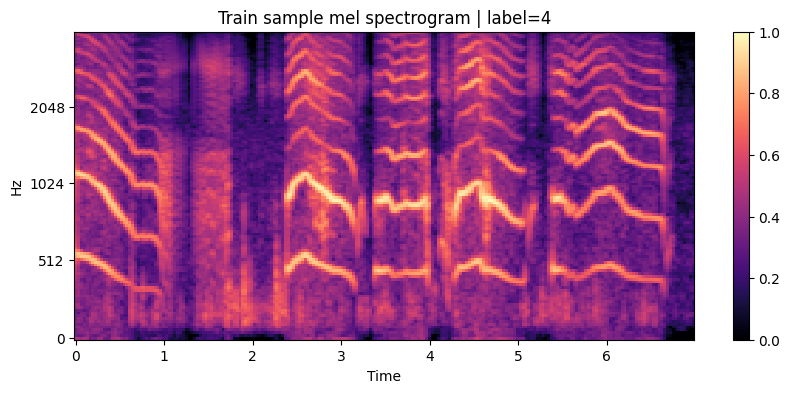

In [24]:
import matplotlib.pyplot as plt
import librosa.display
import random

idx = random.randint(0, len(X_train)-1)
spec = X_train[idx][0]  # remove channel

plt.figure(figsize=(10,4))
librosa.display.specshow(spec, x_axis="time", y_axis="mel", sr=TARGET_SR, hop_length=HOP_LENGTH)
plt.title(f"Train sample mel spectrogram | label={y_train[idx]}")
plt.colorbar()
plt.show()


In [25]:
# Show one spectrogram per class (train preferred, fallback to val/test)
classes_to_show = ['belly_pain','burping','cold_hot','discomfort','hungry','lonely','scared','tired']

samples = []
for cls in classes_to_show:
    if cls not in label2id:
        print(f"Class {cls} not in label map, skipping")
        continue
    lbl = label2id[cls]
    found = False
    if 'y_train' in globals():
        idxs = np.where(y_train == lbl)[0]
        if idxs.size > 0:
            samples.append((cls, 'train', idxs[0], X_train[idxs[0]][0]))
            found = True
    if not found and 'y_val' in globals():
        idxs = np.where(y_val == lbl)[0]
        if idxs.size > 0:
            samples.append((cls, 'val', idxs[0], X_val[idxs[0]][0]))
            found = True
    if not found and 'y_test' in globals():
        idxs = np.where(y_test == lbl)[0]
        if idxs.size > 0:
            samples.append((cls, 'test', idxs[0], X_test[idxs[0]][0]))
            found = True
    if not found:
        print(f"No example found for class {cls} in any split")

# Plot grid and save images
out_dir = "../data/processed/images"
os.makedirs(out_dir, exist_ok=True)

n = len(samples)
if n == 0:
    print("No samples found to display")
else:
    cols = 4
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = axes.flatten()

    saved = []
    for i, (cls, split, idx, spec) in enumerate(samples):
        ax = axes[i]
        img = librosa.display.specshow(spec, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax, cmap='magma')
        ax.set_title(f"{cls} ({split}) idx={idx}")
        ax.set_xticks([])
        ax.set_yticks([])

        # save individual image
        plt.figure(figsize=(6,3))
        librosa.display.specshow(spec, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')
        plt.title(f"{cls} ({split}) idx={idx}")
        plt.colorbar(format='%+2.0f dB')
        pf = os.path.join(out_dir, f"{cls}_{split}_{idx}.png")
        plt.savefig(pf, dpi=150, bbox_inches='tight')
        plt.close()
        saved.append(pf)

    # hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    grid_path = os.path.join(out_dir, "per_class_grid.png")
    plt.savefig(grid_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"Saved grid: {grid_path}")
    print("Saved individual images:")
    for s in saved:
        print(" -", s)


Saved grid: ../data/processed/images/per_class_grid.png
Saved individual images:
 - ../data/processed/images/belly_pain_train_81.png
 - ../data/processed/images/burping_train_55.png
 - ../data/processed/images/cold_hot_train_15.png
 - ../data/processed/images/discomfort_train_30.png
 - ../data/processed/images/hungry_train_0.png
 - ../data/processed/images/lonely_train_46.png
 - ../data/processed/images/scared_train_17.png
 - ../data/processed/images/tired_train_28.png


In [26]:
X_train

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.33155247e-02, 7.12928772e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.31693664e-02, 7.24947900e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          7.52566308e-02, 1.09794900e-01, 2.79712665e-04],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],


       [[[5.28696068e-02, 1.58309940e-05, 0.00000000e+00, ...,
          4.68597421e-03, 0.00000000e+00, 1.66587834e-03],
         [5.86575493e-02, 4.76703653e-03, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      